The spatial heterogeneity in the Fram Strait can be considered across at least five main points:
1. Proximity to the coast/landfast ice edge
2. Proximity to the sea ice edge
3. North-south distance
4. Sea ice concentration
5. Sea ice thickness

Both the sea ice thickness and sea ice concentration are expected to be lowest by the sea ice edge, as well as to have a north-south gradient, as thick ice from the central Arctic makes its way through the Strait and is advected southward along the Greenland coast. 


In [168]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import powerlaw
import os
import proplot as pplt

In [110]:
temp = []
for year in range(2003, 2021):
    temp.append(pd.read_csv('../data/floe_tracker/ift_floe_property_tables/with_nsidc/ift_floe_properties_{y}.csv'.format(y=year),
                            parse_dates=True))
df = pd.concat(temp)
df['datetime'] = pd.to_datetime(df['datetime'].values)
df = df.loc[(df.datetime.dt.dayofyear >= 91) & (df.datetime.dt.dayofyear <= 258)]

In [111]:
df['perim_km'] = df.perimeter*.25
df['area_km2'] = df.area*.25*.25
df['area_adj_km2'] = (np.sqrt(df.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual
df['doy'] = df.datetime.dt.dayofyear
df['year'] = df.datetime.dt.year

## Compare low vs high SIC
The data are divided first into greater than or less than 80% SIC. Then, data is pooled by day of year, and if there are at least 300 floes in the category, then the truncated power law is fit to the data.

In [85]:
df_lt8=df[df.nsidc_sic<=.8]
df_gt8=df[df.nsidc_sic>.8]
cond1=r'SIC $\leq$ 80%'
cond2=r'SIC > 80%'

In [86]:
%%time
doys_lt=[]
doys_gt=[]
alphas_lt=[]
alphas_gt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt8[df_lt8.doy==d]
    df_gt_temp=df_gt8[df_gt8.doy==d]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_adj_km2
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt=np.append(alphas_lt,fit.truncated_power_law.alpha)
        doys_lt=np.append(doys_lt,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_adj_km2
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt=np.append(alphas_gt,fit.truncated_power_law.alpha)
        doys_gt=np.append(doys_gt,d)

CPU times: user 56.1 s, sys: 214 ms, total: 56.3 s
Wall time: 56.5 s


Next, a smoothed estimate is made by grouping data within a 5 day window. (I'm not sure that this method is right though, since it's going to lose some of the independence between images. And it's different than the method used in the first part of the paper).

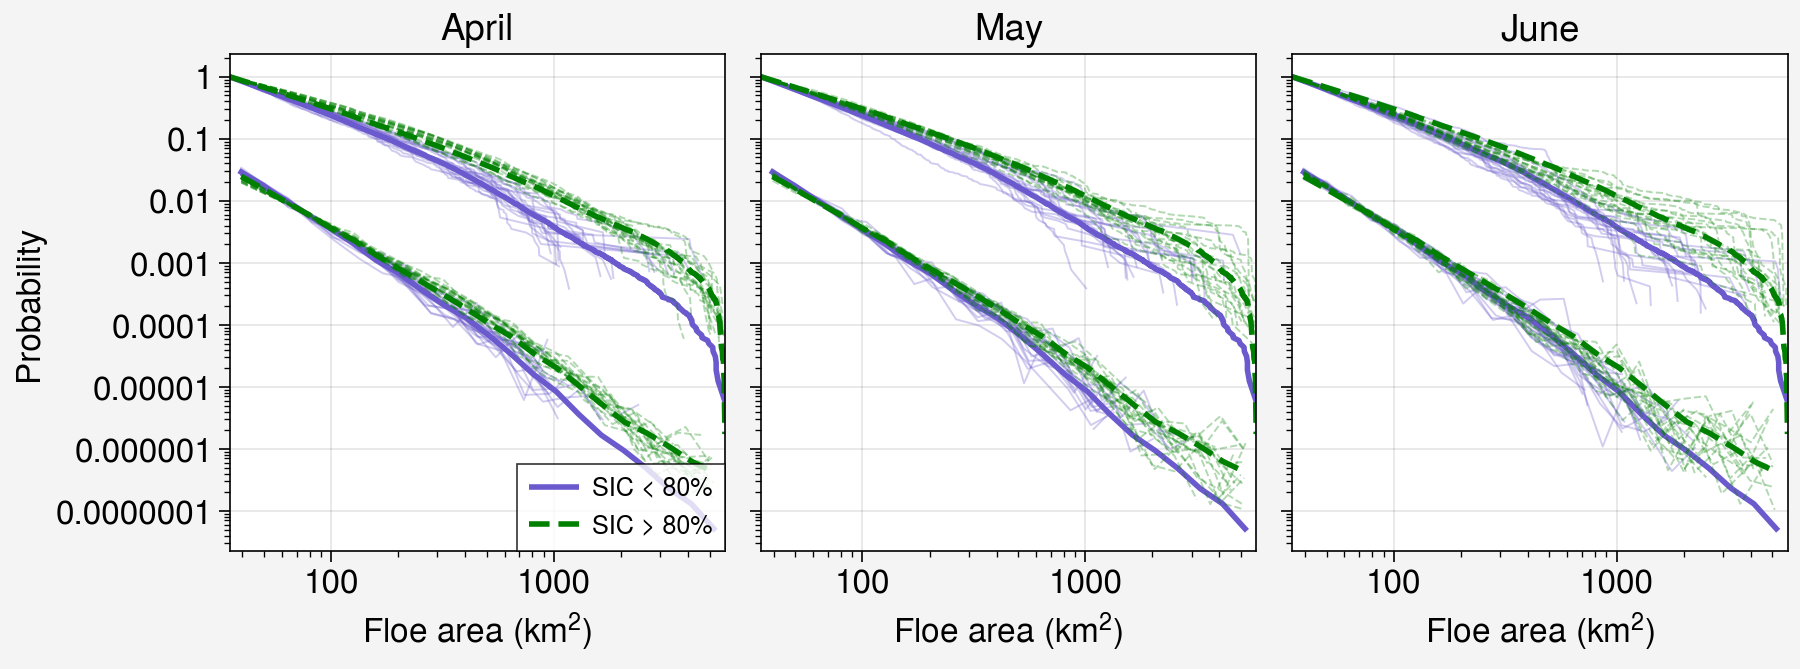

In [129]:
fig, axs = pplt.subplots(width=9, ncols=3, spanx=False)
xmax=90000
months = {4: 'April', 5: 'May', 6: 'June'}
for ax, month in zip(axs, [4, 5, 6]):
    # SIC < 0.8 
    df_subset = df_lt8.loc[df_lt8.datetime.dt.month == month]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area_adj_km2
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='slateblue', linewidth=0.7, ax=ax, label='', alpha=0.3)
        fit.plot_ccdf(color='slateblue', linewidth=0.7, ax=ax, alpha=0.3)
    data = df_lt8.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='slateblue', linewidth=2, ax=ax, label='SIC < 80%')
    fit.plot_ccdf(color='slateblue', linewidth=2, ax=ax)

    # SIC > 0.8
    df_subset = df_gt8.loc[df_gt8.datetime.dt.month == month]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area_adj_km2
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='green', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
        fit.plot_ccdf(color='green', linewidth=0.7, ax=ax, alpha=0.3, ls='--')
    data = df_gt8.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='green', linewidth=2, ax=ax, label='SIC > 80%', ls='--')
    fit.plot_ccdf(color='green', linewidth=2, ax=ax, ls='--')
    
    ax.format(xlabel='Floe area (km$^2$)', ylabel='Probability', fontsize=12, title=months[month])
axs[0].legend(loc='lr', ncols=1)    
    # fig.save('../figures/fig09_all_floes_v_tracked_FSD.png')
    # fig.save('../figures/fig09_all_floes_v_tracked_FSD.pdf')

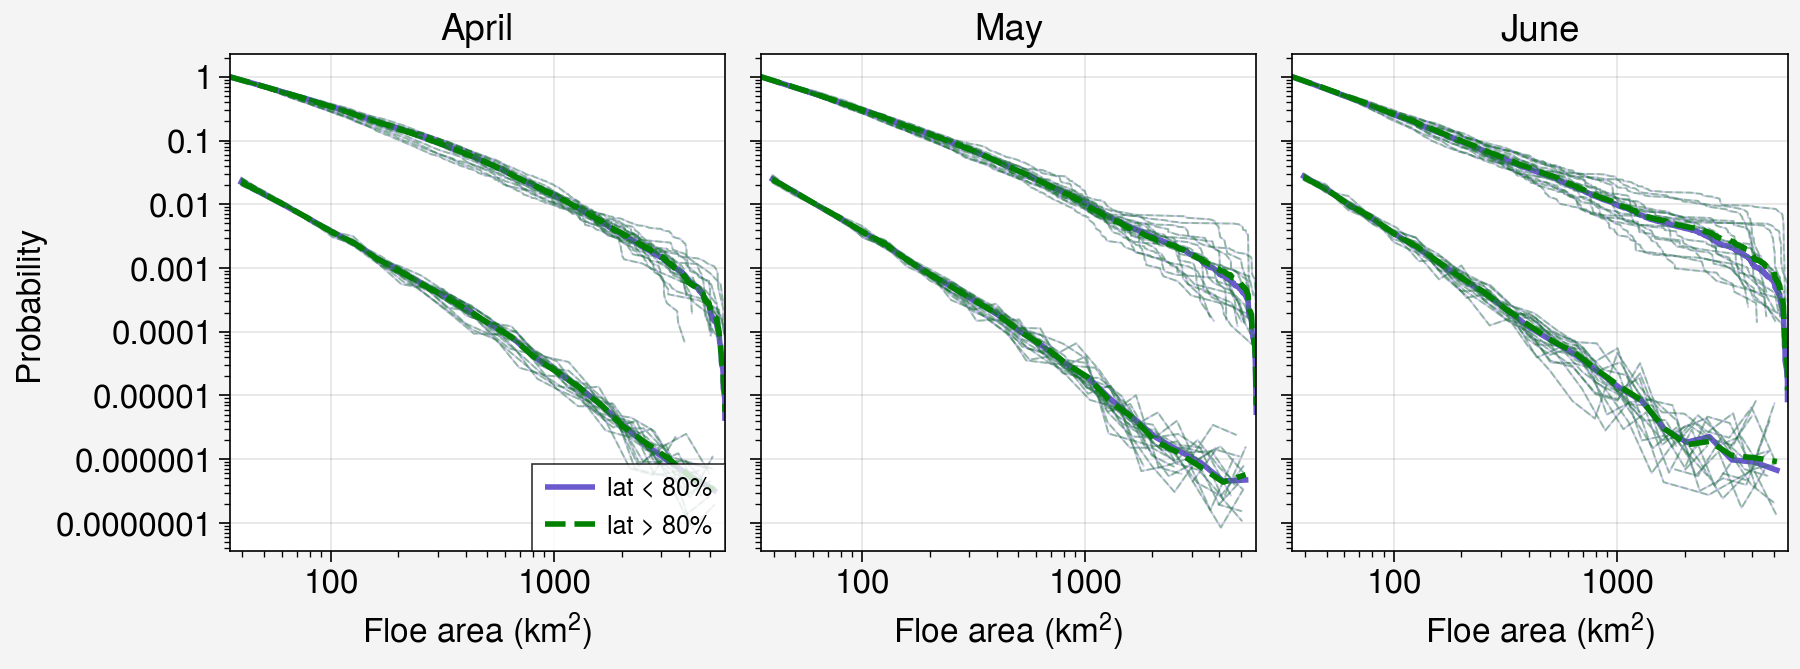

In [167]:
# data = group.area_adj_km2
# fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
# fit.truncated_power_law.plot_pdf()
# fit.power_law.plot_pdf()
# fit.distribution_compare('truncated_power_law', 'power_law')
fig, axs = pplt.subplots(width=9, ncols=3, spanx=False)
xmax=90000
months = {4: 'April', 5: 'May', 6: 'June'}
for ax, month in zip(axs, [4, 5, 6]):
    # SIC < 0.8 
    df_subset = df_gt8.loc[df_gt8.datetime.dt.month == month]
    df_subset = df_subset.loc[df_subset.latitude < 80]
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area_adj_km2
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='slateblue', linewidth=0.7, ax=ax, label='', alpha=0.3)
        fit.plot_ccdf(color='slateblue', linewidth=0.7, ax=ax, alpha=0.3)
        
    df_subset = df_gt8.loc[df_gt8.datetime.dt.month == month]
    data = df_subset.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='slateblue', linewidth=2, ax=ax, label='lat < 80%')
    fit.plot_ccdf(color='slateblue', linewidth=2, ax=ax)

    # SIC > 0.8
    df_subset = df_gt8.loc[df_gt8.datetime.dt.month == month]
    df_subset = df_subset.loc[df_subset.latitude < 80]
    
    for year, group in df_subset.groupby(df_subset.datetime.dt.year):
        data = group.area_adj_km2
        fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
        fit.plot_pdf(color='green', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
        fit.plot_ccdf(color='green', linewidth=0.7, ax=ax, alpha=0.3, ls='--')
    
    df_subset = df_subset.loc[df_subset.latitude < 80]
    data = df_subset.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='green', linewidth=2, ax=ax, label='lat > 80%', ls='--')
    fit.plot_ccdf(color='green', linewidth=2, ax=ax, ls='--')
    
    ax.format(xlabel='Floe area (km$^2$)', ylabel='Probability', fontsize=12, title=months[month])
axs[0].legend(loc='lr', ncols=1)    
    # fig.save('../figures/fig09_all_floes_v_tracked_FSD.png')
    # fig.save('../figures/fig09_all_floes_v_tracked_FSD.pdf')

In [146]:
%%time
# Alternate approach - pooling across all years
# Same thing grouped by DOY
x_min = 35
n_threshold = 300
results_lt = []
for doy, df_doy in df_lt8.groupby(df_lt8.datetime.dt.dayofyear):
    for satellite, group in df_doy.groupby('satellite'): 
        if len(group.loc[group.area_adj_km2 > x_min]) > n_threshold:
            area = group.area_adj_km2
            fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
            results_lt.append([doy, satellite, len(df_doy),
                                fit.power_law.alpha,
                                fit.truncated_power_law.alpha,
                                fit.truncated_power_law.parameter2,
                                fit.power_law.D,
                                fit.truncated_power_law.D,
                            ])
results_lt = pd.DataFrame(results_lt, columns=['doy', 'satellite', 'n',
                                               'alpha', 'alpha_tpl', 'lambda_tpl',
                                               'D_PL', 'D_TPL',
                                                ])        
        
results_lt['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(results_lt.doy, 'D')).dt.month

CPU times: user 19.1 s, sys: 50.2 ms, total: 19.1 s
Wall time: 19.2 s


In [135]:
%%time
# Alternate approach - pooling across all years
# Same thing grouped by DOY
x_min = 35
n_threshold = 300
results_gt = []
for doy, df_doy in df_gt8.groupby(df_gt8.datetime.dt.dayofyear):
    for satellite, group in df_doy.groupby('satellite'): 
        if len(group.loc[group.area_adj_km2 > x_min]) > n_threshold:
            area = group.area_adj_km2
            fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
            results_gt.append([doy, satellite, len(df_doy),
                                fit.power_law.alpha,
                                fit.truncated_power_law.alpha,
                                fit.truncated_power_law.parameter2,
                                fit.power_law.D,
                                fit.truncated_power_law.D,
                            ])
results_gt = pd.DataFrame(results_gt, columns=['doy', 'satellite', 'n',
                                               'alpha', 'alpha_tpl', 'lambda_tpl',
                                               'D_PL', 'D_TPL',
                                               ])        
        
results_gt['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(results_gt.doy, 'D')).dt.month

CPU times: user 51 s, sys: 115 ms, total: 51.1 s
Wall time: 51.1 s


In [163]:
# fig, ax = pplt.subplots()
# ax.hist(results_gt.loc[results_gt.month == 4, 'alpha_tpl'], bins=30, alpha=0.3)
# ax.hist(results_gt.loc[results_gt.month == 5, 'alpha_tpl'], bins=30, alpha=0.3)

SubplotGrid(nrows=1, ncols=1, length=1)

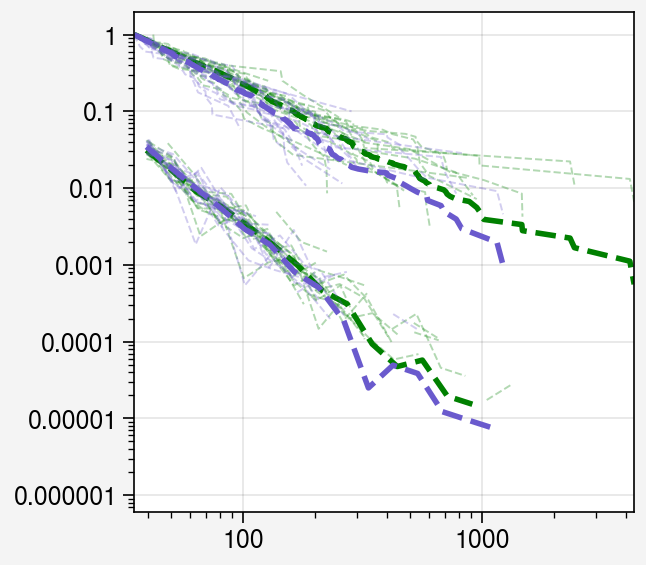

In [160]:
doy = 180
fig, ax = pplt.subplots()
df_subset = df_gt8.loc[df_gt8.datetime.dt.dayofyear == doy]
for year, group in df_subset.groupby(df_subset.datetime.dt.year):
    data = group.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='green', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
    fit.plot_ccdf(color='green', linewidth=0.7, ax=ax, alpha=0.3, ls='--')

data = df_subset.area_adj_km2
fit = powerlaw.Fit(data, xmin=35, xmax=xmax)
fit.plot_pdf(color='green', linewidth=2, ax=ax, label='SIC > 80%', ls='--')
fit.plot_ccdf(color='green', linewidth=2, ax=ax, ls='--')


df_subset = df_lt8.loc[df_lt8.datetime.dt.dayofyear == doy]
for year, group in df_subset.groupby(df_subset.datetime.dt.year):
    data = group.area_adj_km2
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    fit.plot_pdf(color='slateblue', linewidth=0.7, ax=ax, label='', alpha=0.3, ls='--')
    fit.plot_ccdf(color='slateblue', linewidth=0.7, ax=ax, alpha=0.3, ls='--')

data = df_subset.area_adj_km2
fit = powerlaw.Fit(data, xmin=35, xmax=xmax)
fit.plot_pdf(color='slateblue', linewidth=2, ax=ax, label='SIC < 80%', ls='--')
fit.plot_ccdf(color='slateblue', linewidth=2, ax=ax, ls='--')



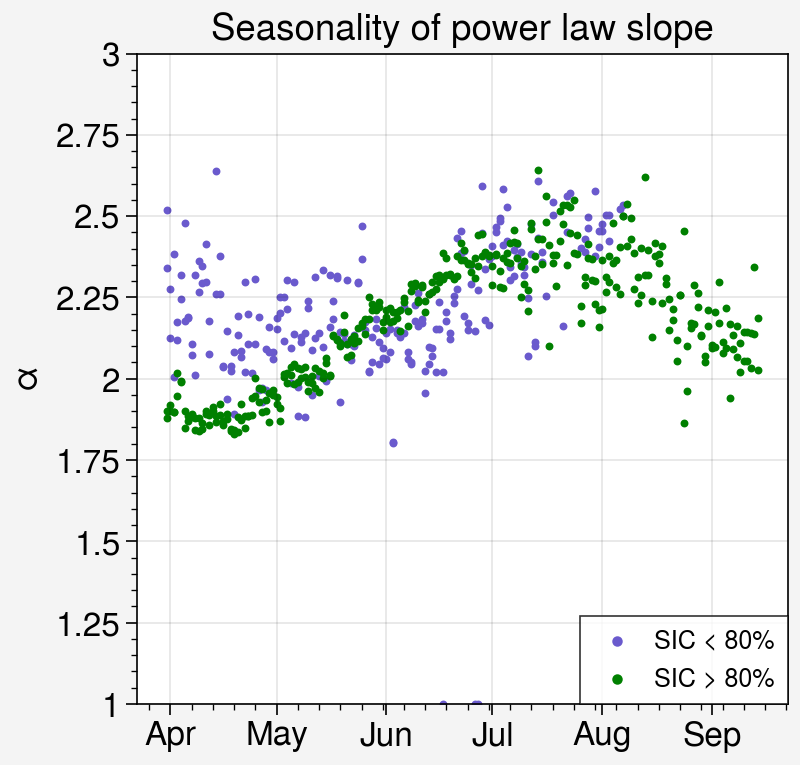

In [152]:
doy = results_gt[['doy', 'month']].groupby('month').mean()['doy']
fig, ax = pplt.subplots(width=4)
n_threshold = 100 
month_threshold = 300
variable = 'alpha_tpl'
time_idx = (results_lt.month != 3) & (results_lt.month <= 9)
# df_pivot = results_lt.loc[time_idx & (results_lt.n > n_threshold)].pivot_table(index='datetime', values=variable, columns='month')
# month_counts = df_pivot.notnull().sum() 
# month_idx = [m for m in month_counts.index if month_counts[m] > month_threshold]
month_idx = [4, 5, 6, 7]
# _ = ax.box(doy[month_idx].values/30, df_pivot[month_idx], facecolor='w', alpha=0.7, zorder=1, lw=1.5, marker='')
_ = ax.scatter(results_lt.doy/30, results_lt[variable], marker='o', ms=5, zorder=0, label='SIC < 80%', color='slateblue')
_ = ax.scatter(results_gt.doy/30, results_gt[variable], marker='o', ms=5, zorder=0, color='green', label='SIC > 80%')

ax.format(ylim=(1, 3), xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', ylabel='$\\alpha$', title='Seasonality of power law slope', fontsize=12)
ax.legend(loc='lr', ncols=1, ms=10, fontsize=12)

# PDF for publication, PNG for slides
# fig.save('../figures/fig07_fsd_slope.pdf', dpi=300)
# fig.save('../figures/fig07_fsd_slope.png', dpi=300)

In [ ]:
# Could it be that the seasonal cycle is dominated by the higher ice concentration region, and that MIZ is less affected?

In [107]:
%%time
doys_lt_s=[]
doys_gt_s=[]
alphas_lt_s=[]
alphas_gt_s=[]
sigs_gt=[]
sigs_lt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt8[(df_lt85.doy>(d-2))&(df_lt85.doy<(d+2))]
    df_gt_temp=df_gt8[(df_gt85.doy>(d-2))&(df_gt85.doy<(d+2))]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_adj_km2
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt_s=np.append(alphas_lt_s,fit.truncated_power_law.alpha)
        sigs_lt=np.append(sigs_lt,fit.power_law.sigma)
        doys_lt_s=np.append(doys_lt_s,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_adj_km2
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt_s=np.append(alphas_gt_s,fit.truncated_power_law.alpha)
        sigs_gt=np.append(sigs_gt,fit.power_law.sigma)
        doys_gt_s=np.append(doys_gt_s,d)

CPU times: user 1min 45s, sys: 180 ms, total: 1min 45s
Wall time: 1min 45s


In [100]:
alphas1=[]
sigmas1=[]
for dist in np.arange(0,550,50):
    df_temp1=df[(df.edge_dist_km>dist)&(df.edge_dist_km<=(dist+50))]
    data1=df_temp1.area_adj_km2
    if len(data>300):
        fit1 = powerlaw.Fit(data1, xmin=35)
        sigmas1= np.append(sigmas1, fit1.sigma)
        alphas1= np.append(alphas1, fit1.truncated_power_law.alpha)
        
alphas2=[]
sigmas2=[]
for dist in np.arange(0,450,50):
    df_temp2=df[(df.coast_dist_km>dist)&(df.coast_dist_km<=(dist+50))]
    data2=df_temp2.area_adj_km2
    if len(data>300):
        fit2 = powerlaw.Fit(data2, xmin=35)
        sigmas2= np.append(sigmas2, fit2.sigma)
        alphas2= np.append(alphas2, fit2.truncated_power_law.alpha)

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


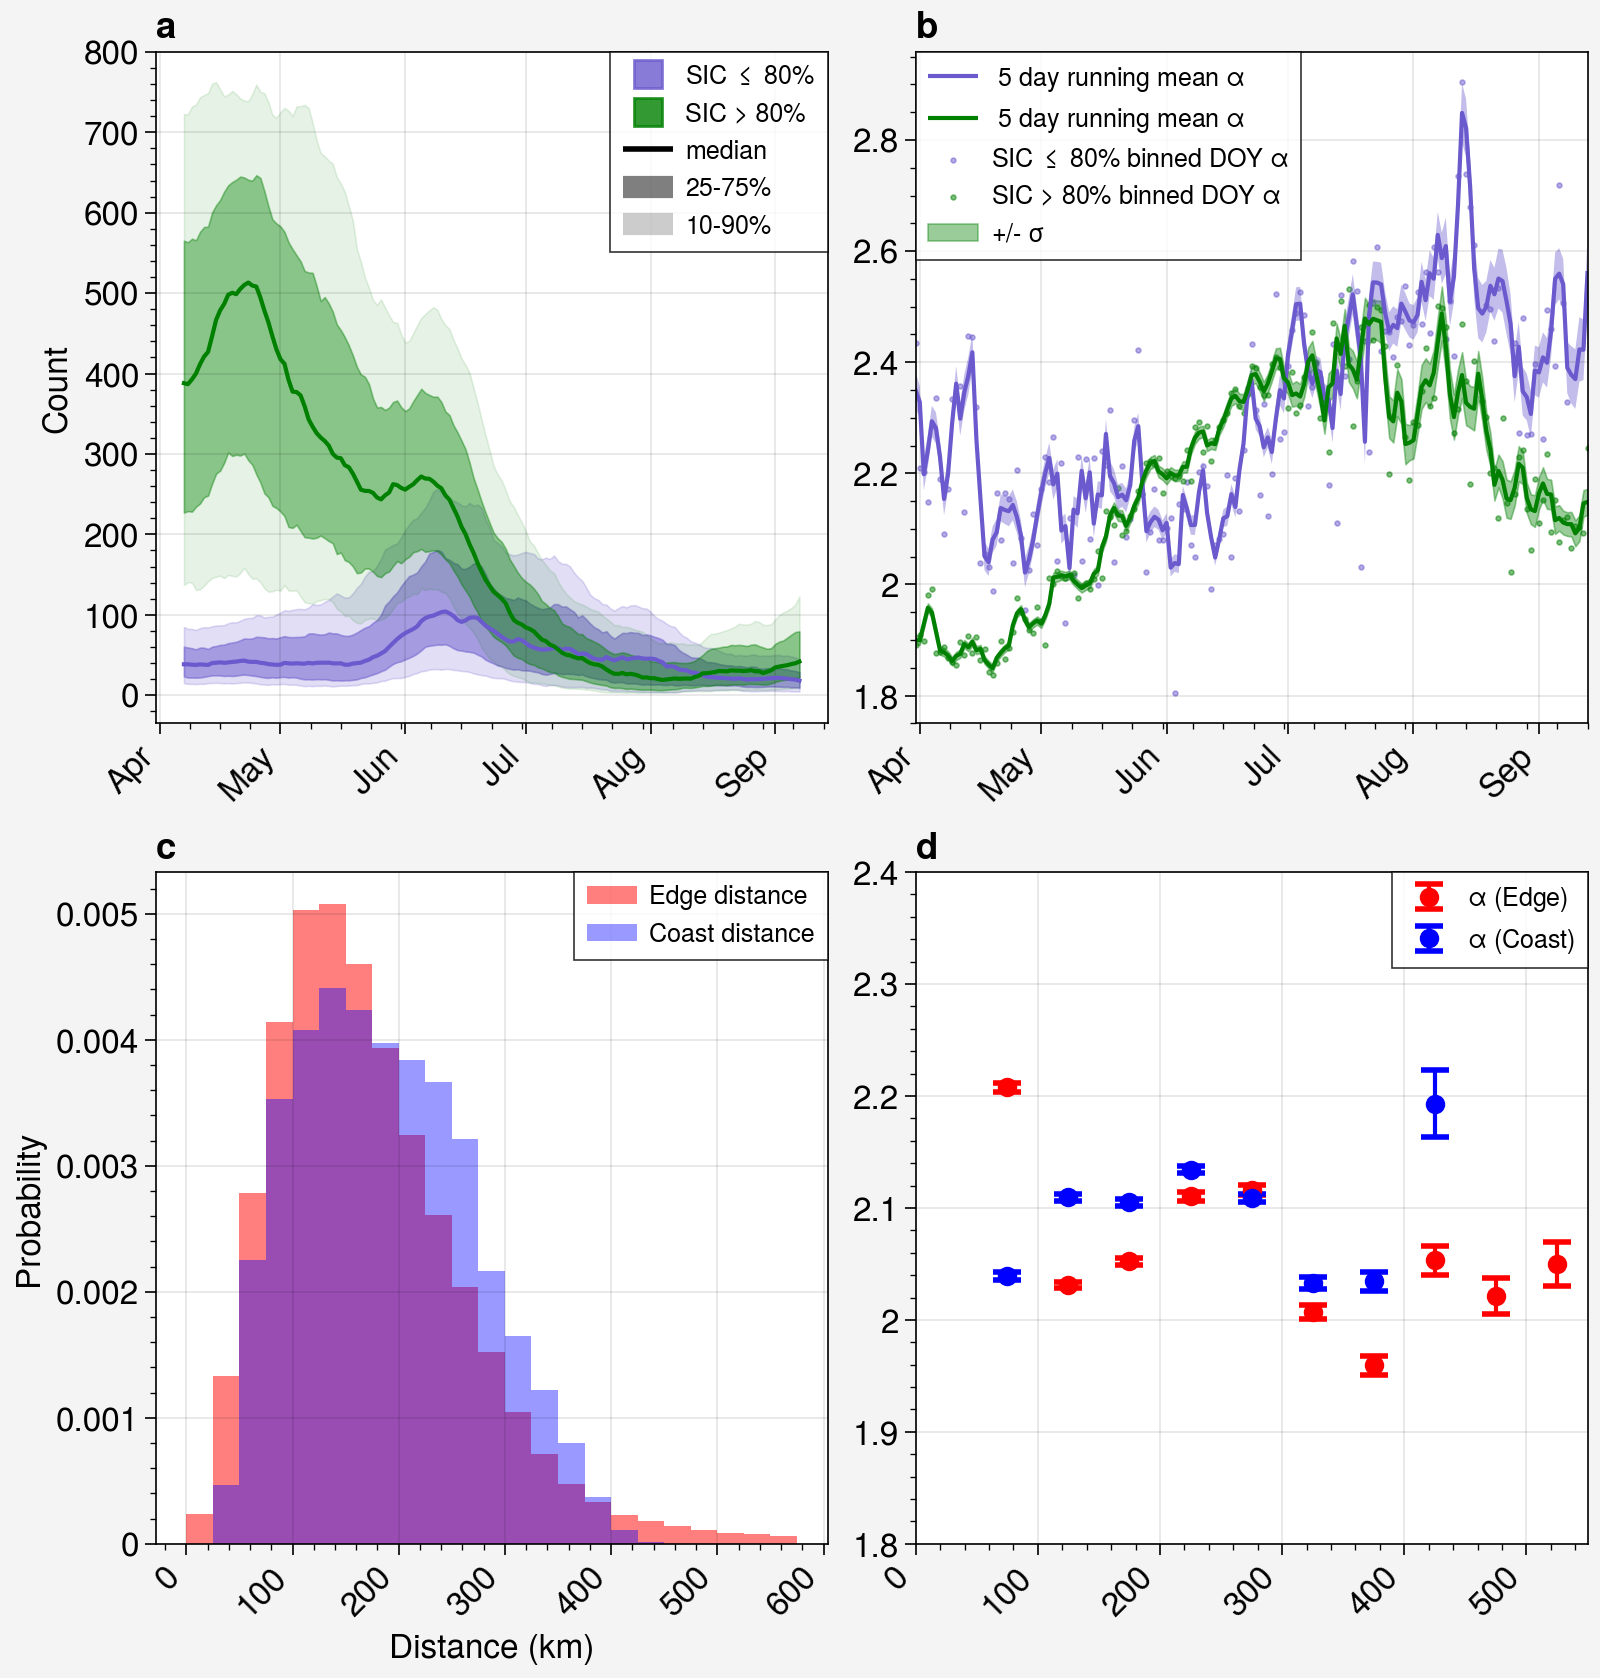

In [171]:
import proplot as pplt

count_range_lt85 = df_lt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_lt85 = count_range_lt85.T.rolling(15, center=True).mean()

count_range_gt85 = df_gt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_gt85 = count_range_gt85.T.rolling(15, center=True).mean()

fig, axs = pplt.subplots(ncols=2, nrows=2, width=8, share=False)
ax = axs[0]
ax.plot(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.5],color='slateblue',label=cond1+r' Median')
ax.fill_between(smoothed_count_range_lt85.index,
                   smoothed_count_range_lt85[0.25],
                   smoothed_count_range_lt85[0.75],
                   color= 'slateblue',alpha=0.5,label='')
ax.fill_between(smoothed_count_range_lt85.index,
                   smoothed_count_range_lt85[0.1],
                   smoothed_count_range_lt85[0.9],
                   color='slateblue',
                   alpha=0.2,
                   label=r'10-90%')

ax.plot(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.5],color='green',label=cond2+' Median')
ax.fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.25],smoothed_count_range_gt85[0.75],color='green',alpha=0.4,
                   label='')
ax.fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.1],smoothed_count_range_gt85[0.9],color='green',alpha=0.1,label='10-90%')


dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax.format(xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr]);
ax.format(ylabel='Count', xlabel='')

# ax[0].legend(fontsize=12, ncols=1)
h = [ax.plot([],[], lw=lw, alpha=a, color=c, marker=m, ms=10) for lw, a, c, m in zip([0, 0, 2, 8, 8], [0.8, 0.8, 1, 0.5, 0.2],
                                                                            ['slateblue', 'green', 'k', 'k', 'k'],
                                                                             ['s', 's', '', '', ''])]
l = [cond1, cond2, 'median', r'25-75%', r'10-90%']
ax.legend(h, l, ncols=1)

#### Data by day of year ######
ax = axs[1]
ax.scatter(doys_lt,alphas_lt,color='slateblue',s=3,alpha=0.5,label=cond1+r' binned DOY $\alpha$' )
ax.plot(doys_lt_s,alphas_lt_s,color='slateblue',label= r' 5 day running mean $\alpha$',
       shadedata=sigs_lt)
# ax.fill_between(doys_lt_s,alphas_lt_s-sigs_lt,alphas_lt_s+sigs_lt,color='slateblue',alpha=0.4,label=r'+/- $\sigma$')

ax.scatter(doys_gt,alphas_gt,color='green',s=3,alpha=0.5,label=cond2+r' binned DOY $\alpha$')
ax.plot(doys_gt_s,alphas_gt_s,color='green',label=r' 5 day running mean $\alpha$')
ax.fill_between(doys_gt_s,alphas_gt_s-sigs_gt,alphas_gt_s+sigs_gt,color='green',alpha=0.4,label=r'+/- $\sigma$')

dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax.format(xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr], xlabel='');
ax.legend(fontsize=12, ncols=1)
axs.format(abc=True, fontsize=12, xrotation=45)

ax = axs[2]
ax.hist(df.edge_dist_km, color='r', alpha=0.5, density=True, bins=range(0, 600, 25), label='Edge distance')
ax.hist(df.coast_dist_km, color='b', alpha=0.4, density=True, bins=range(0, 600, 25), label='Coast distance')
ax.legend(loc='ur', ncols=1)
ax.format(ylabel='Probability', xlabel='Distance (km)')

ax = axs[3]
ax.errorbar(np.arange(0,550,50)+25,alphas1, yerr=sigmas1,
            c='r', fmt='o', ecolor='r', capsize=5, capthick=2, linestyle='None', markersize=6,
            label=r'$\alpha$ (Edge)')
#plt.scatter(np.arange(0,450,50),alphas2)
ax.errorbar(np.arange(0,450,50)+25,alphas2, yerr=sigmas2,c='b', fmt='o',  ecolor='b', capsize=5, capthick=2,
            linestyle='None', markersize=6,label=r'$\alpha$ (Coast)')
ax.legend(loc='ur', ncols=1)
ax.format(ylim=(1.8, 2.4))
# 
# ax.legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')
fig.save('../figures/fig0X_fsd_sic.png')

## compare edge dist

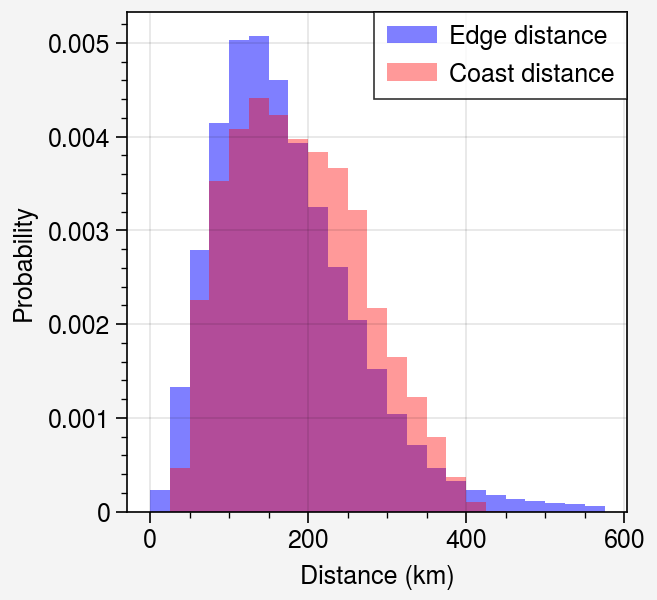

In [59]:
fig, ax = pplt.subplots()
ax.hist(df.edge_dist_km, color='b', alpha=0.5, density=True, bins=range(0, 600, 25), label='Edge distance')
ax.hist(df.coast_dist_km, color='r', alpha=0.4, density=True, bins=range(0, 600, 25), label='Coast distance')
ax.legend(loc='ur', ncols=1)
ax.format(ylabel='Probability', xlabel='Distance (km)')

Text(0, 0.5, '$\\alpha$')

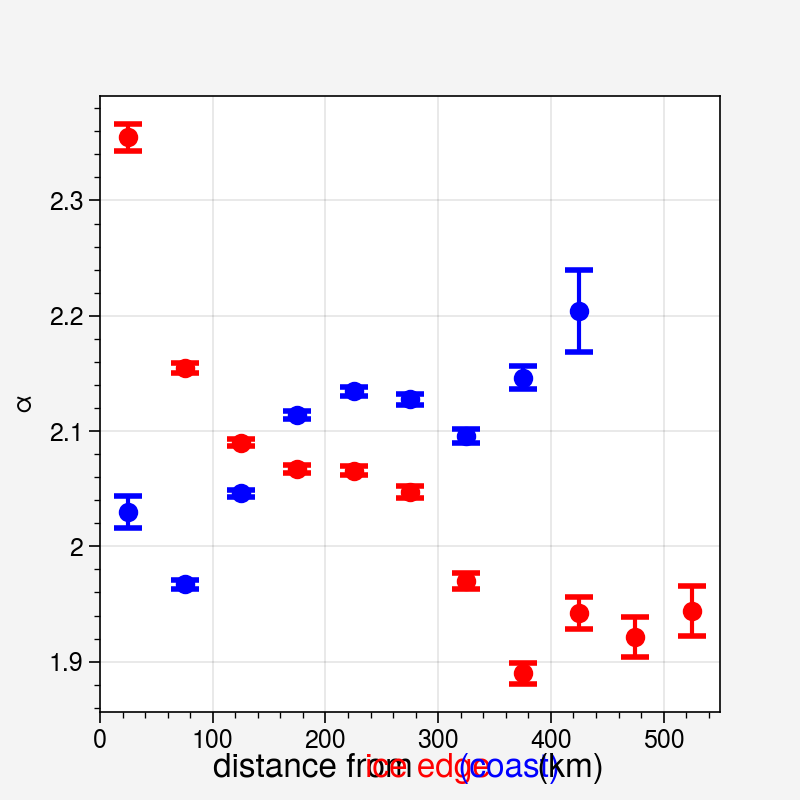

In [60]:
#plt.scatter(np.arange(0,550,50),alphas1)
plt.errorbar(np.arange(0,550,50)+25,alphas1, yerr=sigmas1,c='red', fmt='o', ecolor='red', capsize=5, capthick=2, linestyle='None', markersize=6,label=r'$\alpha$')
#plt.scatter(np.arange(0,450,50),alphas2)
plt.errorbar(np.arange(0,450,50)+25,alphas2, yerr=sigmas2,c='blue', fmt='o',  ecolor='blue', capsize=5, capthick=2, linestyle='None', markersize=6,label=r'$\alpha$')
plt.text(100, 1.8, 'distance from ', color='black', fontsize=12)
plt.text(235, 1.8, 'ice edge', color='red', fontsize=12)
plt.text(310, 1.8, ' (coast)', color='blue', fontsize=12)
plt.text(380, 1.8, ' (km) ', color='black', fontsize=12)

plt.ylabel(r'$\alpha$')
# plt.savefig('/Volumes/Extreme SSD/Documents/Analysis/FSD/dist_edge_coast.png')

## separate coast and ice edge

In [266]:
from matplotlib.cm import get_cmap

In [264]:
len(np.arange(0,550,50))

11

In [343]:
# Get the Viridis colormap
cmap = get_cmap('viridis')

# Number of discrete colors you want
n_colors = len(np.arange(0,500,20))

# Create a list of discrete colors by sampling the colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]

/var/folders/hb/fq6r_ywx7yn75m5mg2dr334m0000gr/T/ipykernel_89288/857289581.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


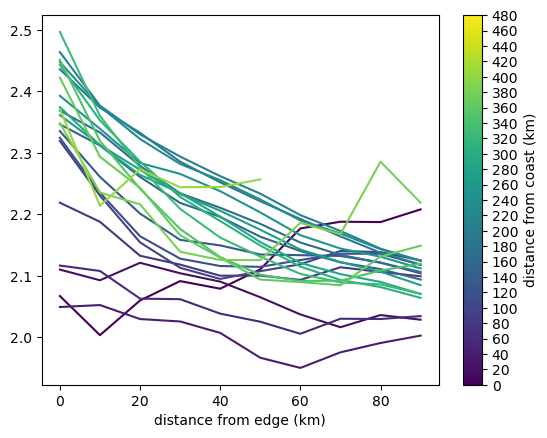

In [348]:
fig,ax=plt.subplots(1,1)
a=0
for dist_c in np.arange(0,500,20):
    alphas1=[]
    sigmas1=[]
    dists1=[]
    for dist in np.arange(0,100,10):
        df_temp1=df[(df.edge_dist_km>dist)&(df.edge_dist_km<=(dist+50))&(df.coast_dist_km>dist_c)&(df.coast_dist_km<=(dist_c+50))]
        data1=df_temp1.area_km
        if len(data1)>100:
            fit1 = powerlaw.Fit(data1, xmin=35)
            sigmas1= np.append(sigmas1, fit1.sigma)
            alphas1= np.append(alphas1, fit1.alpha)
            dists1= np.append(dists1,dist)
            #plt.errorbar(dist_c,fit1.alpha, yerr=fit1.sigma, c=colors[a], fmt='o', ecolor=colors[a], capsize=5, capthick=2, linestyle='None', markersize=6)
            # plt.scatter(dist_c,fit1.alpha,alpha=a)
    if any(dists1):
        plt.plot(dists1,alphas1, c=colors[a],label='dist from coast= '+str(dist_c))
    a+=1
# plt.ylim(1.5,3)
plt.xlabel('distance from edge (km)')
#plt.legend(ncols=2)
# Create the ScalarMappable for the colorbar
sm = ScalarMappable(cmap = 'viridis', norm=Normalize(vmin=0, vmax=len(np.arange(0,500,20)) - 1))
sm.set_array([])  # Needed for ScalarMappable but not used for this type of plot

# Add the colorbar
cbar = plt.colorbar(sm, ticks=range(n_colors),ax=ax)
cbar.set_label('distance from coast (km)')
cbar.set_ticklabels([str(b) for b in np.arange(0,500,20)])

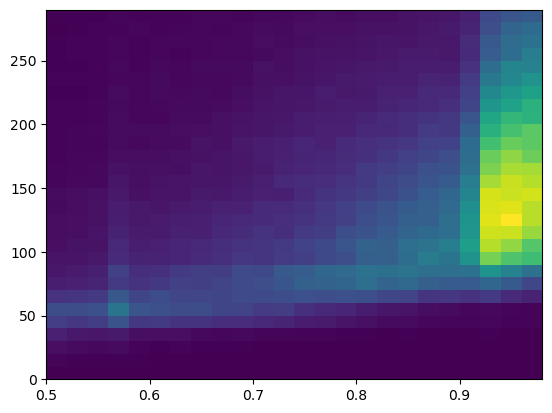

In [354]:
plt.hist2d(df.nsidc_sic,df.edge_dist_km,bins=(np.arange(.5,1,.02),np.arange(0,300,10)));

## compare coast dist

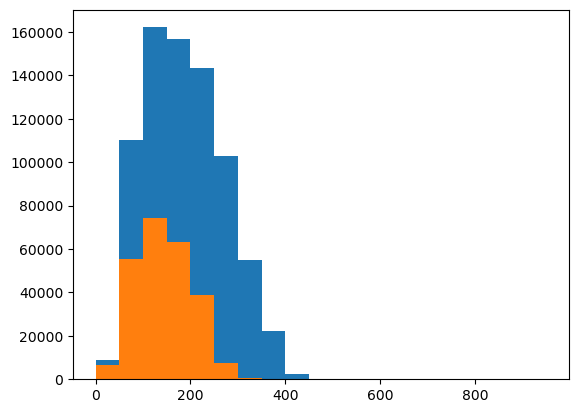

In [200]:
plt.hist(df.coast_dist_km,bins=np.arange(0,1000,50));
plt.hist(df[df.edge_dist_km>200].coast_dist_km,bins=np.arange(0,1000,50));

In [206]:
df_lt85=df[(df.coast_dist_km<=140)&(df.edge_dist_km>200)]
df_gt85=df[(df.coast_dist_km>140)&(df.edge_dist_km>200)]
cond1=r'Distance from coast $\leq$ 140 km'
cond2=r'Distance from coast > 140 km'

In [207]:
doys_lt=[]
doys_gt=[]
alphas_lt=[]
alphas_gt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[df_lt85.doy==d]
    df_gt_temp=df_gt85[df_gt85.doy==d]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt=np.append(alphas_lt,fit.power_law.alpha)
        doys_lt=np.append(doys_lt,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt=np.append(alphas_gt,fit.power_law.alpha)
        doys_gt=np.append(doys_gt,d)

/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


In [208]:
doys_lt_s=[]
doys_gt_s=[]
alphas_lt_s=[]
alphas_gt_s=[]
sigs_gt=[]
sigs_lt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[(df_lt85.doy>(d-2))&(df_lt85.doy<(d+2))]
    df_gt_temp=df_gt85[(df_gt85.doy>(d-2))&(df_gt85.doy<(d+2))]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt_s=np.append(alphas_lt_s,fit.power_law.alpha)
        sigs_lt=np.append(sigs_lt,fit.power_law.sigma)
        doys_lt_s=np.append(doys_lt_s,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt_s=np.append(alphas_gt_s,fit.power_law.alpha)
        sigs_gt=np.append(sigs_gt,fit.power_law.sigma)
        doys_gt_s=np.append(doys_gt_s,d)

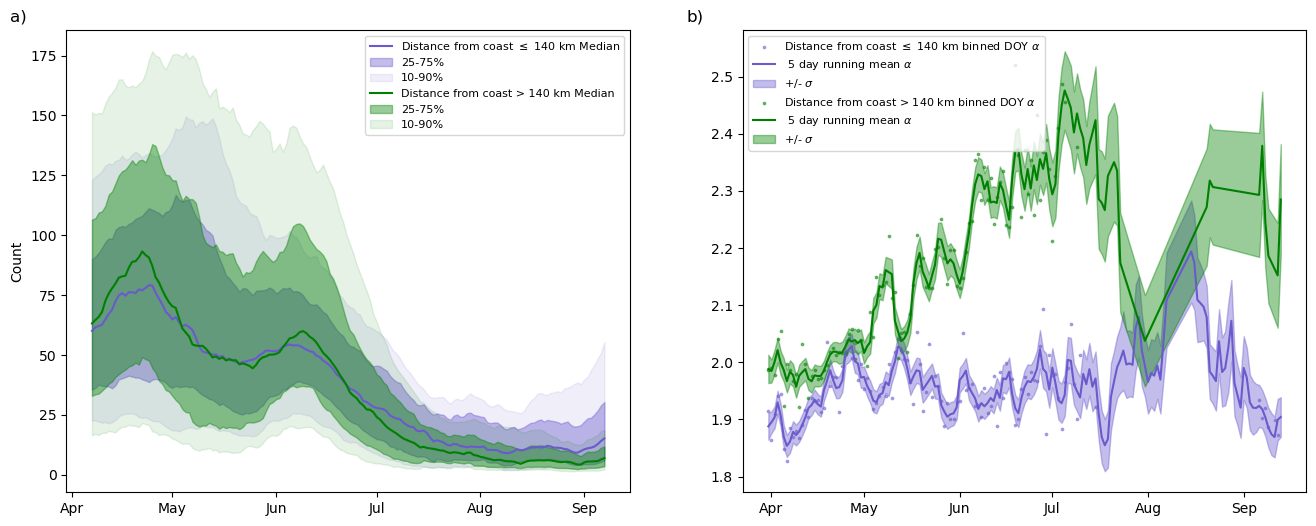

In [209]:
count_range_lt85 = df_lt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_lt85 = count_range_lt85.T.rolling(15, center=True).mean()

count_range_gt85 = df_gt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_gt85 = count_range_gt85.T.rolling(15, center=True).mean()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

ax[0].plot(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.5],color='slateblue',label=cond1+r' Median')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.25],smoothed_count_range_lt85[0.75],color= 'slateblue',alpha=0.4,label=r'25-75%')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.1],smoothed_count_range_lt85[0.9],color='slateblue',alpha=0.1,label=r'10-90%')

ax[0].plot(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.5],color='green',label=cond2+' Median')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.25],smoothed_count_range_gt85[0.75],color='green',alpha=0.4,label='25-75%')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.1],smoothed_count_range_gt85[0.9],color='green',alpha=0.1,label='10-90%')


dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[0].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[0].set_ylabel('Count')

ax[0].legend( fontsize=8)
ax[0].set_title('a)', loc='left', x=-.1)

ax[1].scatter(doys_lt,alphas_lt,color='slateblue',s=3,alpha=0.5,label=cond1+r' binned DOY $\alpha$' )
ax[1].plot(doys_lt_s,alphas_lt_s,color='slateblue',label= r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_lt_s,alphas_lt_s-sigs_lt,alphas_lt_s+sigs_lt,color='slateblue',alpha=0.4,label=r'+/- $\sigma$')

ax[1].scatter(doys_gt,alphas_gt,color='green',s=3,alpha=0.5,label=cond2+r' binned DOY $\alpha$')
ax[1].plot(doys_gt_s,alphas_gt_s,color='green',label=r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_gt_s,alphas_gt_s-sigs_gt,alphas_gt_s+sigs_gt,color='green',alpha=0.4,label=r'+/- $\sigma$')

dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[1].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[1].legend( fontsize=8)
ax[1].set_title('b)', loc='left', x=-.1)
# 
# ax.legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')
# ax.format(ylabel='Count', xlabel='', title='Number of floes per image')
plt.savefig('/Volumes/Extreme SSD/Documents/Analysis/FSD/annals_fig_coast_dist.png')